# ***Oversampling***

## **Librerías y Carga de Datos**


In [5]:
!pip install -q -U transformers accelerate sentencepiece nlpaug wordfreq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.1/362.1 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import nlpaug.augmenter.word as naw
import nlpaug.flow as naf
import re, unicodedata, itertools, warnings, os
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import nlpaug

In [ ]:
#import os
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
root_dir = r"/content/drive/MyDrive/PDG/data/"

path = root_dir + "train_df.xlsx"

In [7]:
train_df = pd.read_excel(path)

etiqueta
0    2138
1     496
Name: count, dtype: int64


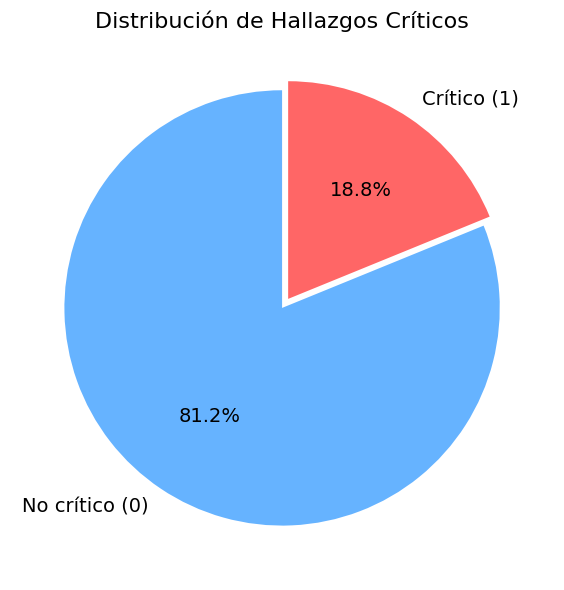

In [8]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

label_counts = train_df["etiqueta"].value_counts().sort_index()
print(label_counts)
labels = ["No crítico (0)", "Crítico (1)"] if set(label_counts.index) == {0,1} else label_counts.index.astype(str)

plt.figure(figsize=(6, 6))
plt.pie(
    label_counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#66b3ff', '#ff6666'],
    explode=[0, 0.05],
    textprops={'fontsize': 14}  # Tamaño del texto en etiquetas y porcentajes
)

plt.title("Distribución de Hallazgos Críticos", fontsize=16)
plt.tight_layout()
plt.show()

# Separar después del gráfico
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['etiqueta'])


# **Aumentador**

In [ ]:
import openai

client = openai.OpenAI(api_key="tu_api_key_aquí")

def paraphrase_openai(text):
    prompt = (
        f"Parafrasea el siguiente informe médico en español manteniendo **exactamente** el mismo significado clínico. "
        f"Usa sinónimos médicos apropiados y cambia la estructura de las frases si es posible. "
        f"No agregues, omitas ni inventes información. La longitud debe ser similar y debe sonar natural para un profesional de la salud. "
        f"Responde solo con la frase parafraseada, sin explicaciones:\n\n\"{text}\""
    )

    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",  # o "gpt-4"
            messages=[{"role": "user", "content": prompt}],
            temperature=0.4,
            max_tokens=150,
        )
        return response.choices[0].message.content.strip()

    except Exception as e:
        print("❌ Error al generar contenido con OpenAI:", e)
        return text


In [ ]:
texto = ("Paciente masculino con fractura de cráneo y evidencia de "
         "hematoma subdural agudo en la convexidad derecha; se observa "
         "desviación de la línea media.")

print("🟢 Original :", texto)
print("🟠 Paráfrasis:", paraphrase_openai(texto))

🟢 Original : Paciente masculino con fractura de cráneo y evidencia de hematoma subdural agudo en la convexidad derecha; se observa desviación de la línea media.
🟠 Paráfrasis: Varón con fractura craneal y hematoma subdural agudo en la convexidad derecha, presentando desviación de la línea media.


### Método oversample

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.utils import shuffle

def oversample(df, text_col="texto", label_col="etiqueta"):
    df_0 = df[df[label_col] == 0]
    df_1 = df[df[label_col] == 1]

    n_needed = len(df_0) - len(df_1)
    print(f"Generando {n_needed} muestras aumentadas para equilibrar clases.")

    def augment_sample(_):
        original = df_1.sample(1)[text_col].values[0]
        try:
            return paraphrase_openai(original)
        except Exception as e:
            print(f"Error parafraseando: {e}")
            return None

    augmented_texts = []
    with ThreadPoolExecutor(max_workers=8) as executor:
        futures = [executor.submit(augment_sample, i) for i in range(n_needed)]
        for future in tqdm(as_completed(futures), total=n_needed, desc="Augmentando textos"):
            result = future.result()
            if result:
                augmented_texts.append(result)

    df_aug = pd.DataFrame({
        text_col: augmented_texts,
        label_col: [1] * len(augmented_texts)
    })

    df_bal = pd.concat([df, df_aug], ignore_index=True)
    df_bal = shuffle(df_bal, random_state=42)
    return df_bal


### Aumentar texto

In [ ]:
train_df

,texto,etiqueta
269,control por perssitencia de cefalea surcos y c...,0
2581,trauma leve con signos de alarma signos de san...,0
176,"contusion febril compleja, antecedentes de ane...",0
584,codigo acv ventana 7h - extenso hematoma subdu...,0
950,nr discreta prominencia de los surcos en las c...,0
...,...,...
1335,"cefalea persistente, trauma craneo encefalico ...",0
1202,emergencia hta surcos y espacio subaracnoideo ...,0
1142,cefalea con signos de alarma. la atenuacion de...,0
1497,herida por proyectil de arma de fuego. signos ...,1


In [ ]:
balanced_train_df = oversample(train_df)

Generando 1313 muestras aumentadas para equilibrar clases.


Augmentando textos:   0%|          | 0/1313 [00:00<?, ?it/s]

### Evaluar aumentador

etiqueta
0    1710
1    1710
Name: count, dtype: int64


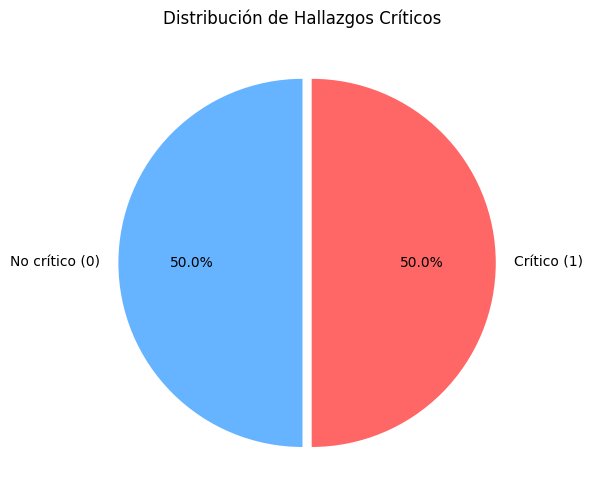

In [ ]:
label_counts = balanced_train_df["etiqueta"].value_counts().sort_index()
print(label_counts)
labels = ["No crítico (0)", "Crítico (1)"] if set(label_counts.index) == {0,1} else label_counts.index.astype(str)

plt.figure(figsize=(6,6))
plt.pie(label_counts,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=['#66b3ff', '#ff6666'],
        explode=[0, 0.05])
plt.title("Distribución de Hallazgos Críticos")
plt.tight_layout()
plt.show()


### Normalización después del oversampling

In [ ]:
def normalize_text(text: str) -> str:
    s = str(text).lower()
    s = unicodedata.normalize("NFKD", s)\
        .encode("ascii", "ignore")\
        .decode("utf-8")
    return re.sub(r"\s+", " ", s).strip()


tqdm.pandas()
def preprocess(text):
    return normalize_text(text)

balanced_train_df["texto"] = balanced_train_df["texto"].progress_apply(preprocess)

  0%|          | 0/3420 [00:00<?, ?it/s]

In [ ]:
n_total = len(balanced_train_df)
n_unique = balanced_train_df["texto"].nunique()
print(f"Filas totales tras limpieza: {n_total}")
print(f"Textos únicos:            {n_unique}")
print(f"Filas duplicadas:         {n_total - n_unique}")

Filas totales tras limpieza: 3420
Textos únicos:            3383
Filas duplicadas:         37


In [ ]:
balanced_train_df = balanced_train_df.drop_duplicates(subset=["texto"], keep="first").reset_index(drop=True)

balanced_train_df.shape

(3383, 2)

etiqueta
0    1685
1    1698
Name: count, dtype: int64


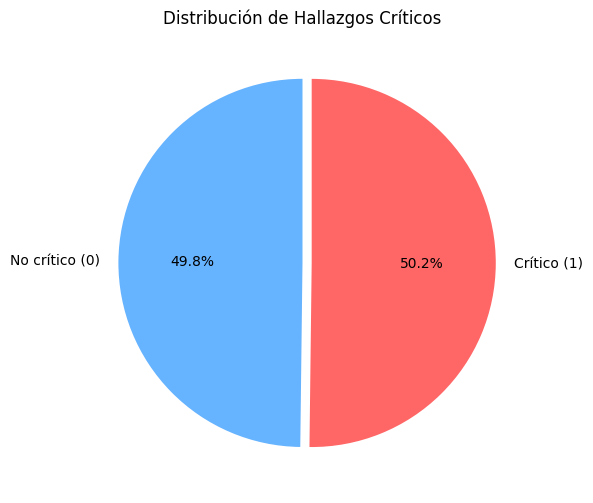

In [ ]:
label_counts = balanced_train_df["etiqueta"].value_counts().sort_index()
print(label_counts)
labels = ["No crítico (0)", "Crítico (1)"] if set(label_counts.index) == {0,1} else label_counts.index.astype(str)

plt.figure(figsize=(6,6))
plt.pie(label_counts,
        labels=labels,
        autopct='%1.1f%%',
        startangle=90,
        colors=['#66b3ff', '#ff6666'],
        explode=[0, 0.05])
plt.title("Distribución de Hallazgos Críticos")
plt.tight_layout()
plt.show()


## **Exportar**

In [ ]:
export_cols = [
    "texto",
    "etiqueta",
]

df_export_train = balanced_train_df[export_cols]

In [ ]:
output_path_train =  root_dir +  "train_oversample_df.xlsx"

In [ ]:
df_export_train.to_excel(output_path_train, index=False)